In [1]:
# %pip install tensorflow
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install pydot

In [2]:
from PIL import Image
from pathlib import Path
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg", ".jpeg", ".bmp"]


def is_valid_image_pillow(file_name):
    try:
        with Image.open(file_name) as img:
            img.verify()
            img = Image.open(file_name)
            if not img.format.lower() in ['png', 'jpeg', 'bmp']:
                print(f"{file_name} is a {img.format}, not accepted by TensorFlow")
                os.remove(file_name)

    except (IOError, SyntaxError) as e:
        print(f"{file_name} is not an image")


for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        is_valid_image_pillow(filepath)
    else:
        print(f"{filepath} not in target extensions")

hair_types\Curly_Hair not in target extensions
hair_types\Straight_Hair not in target extensions
hair_types\Wavy_Hair not in target extensions
hair_types\Curly_Hair\rs_1080x1080-200330130638-1080-ariana-grande-curly-hair-instagram-am-033020.gif not in target extensions


In [3]:
curly_hair_pics = [label for label in Path(data_dir).rglob("Curly_Hair/*")]
straight_hair_pics = [label for label in Path(
    data_dir).rglob("Straight_Hair/*")]
wavy_hair_pics = [label for label in Path(data_dir).rglob("Wavy_Hair/*")]

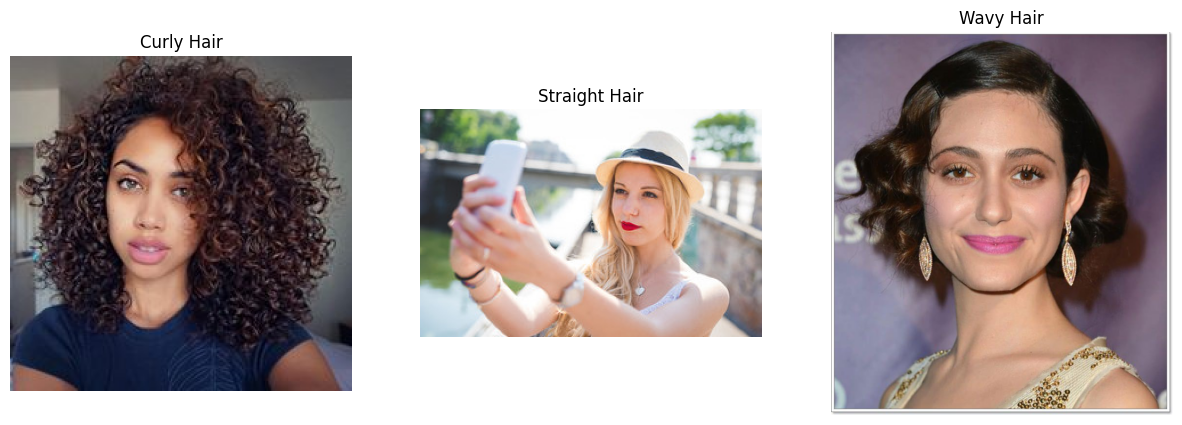

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

img1 = Image.open(str(curly_hair_pics[0]))
img2 = Image.open(str(straight_hair_pics[0]))
img3 = Image.open(str(wavy_hair_pics[0]))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.axis('off')
plt.title('Curly Hair')

plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.axis('off')
plt.title('Straight Hair')

plt.subplot(1, 3, 3)
plt.imshow(img3)
plt.axis('off')
plt.title('Wavy Hair')

plt.show()

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="training",
    seed=999,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types/",
    validation_split=0.2,
    subset="validation",
    seed=999,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

Found 987 files belonging to 3 classes.
Using 790 files for training.
Found 987 files belonging to 3 classes.
Using 197 files for validation.


In [6]:
hair_types_labels = [label.replace("_", " ") for label in train_ds.class_names]

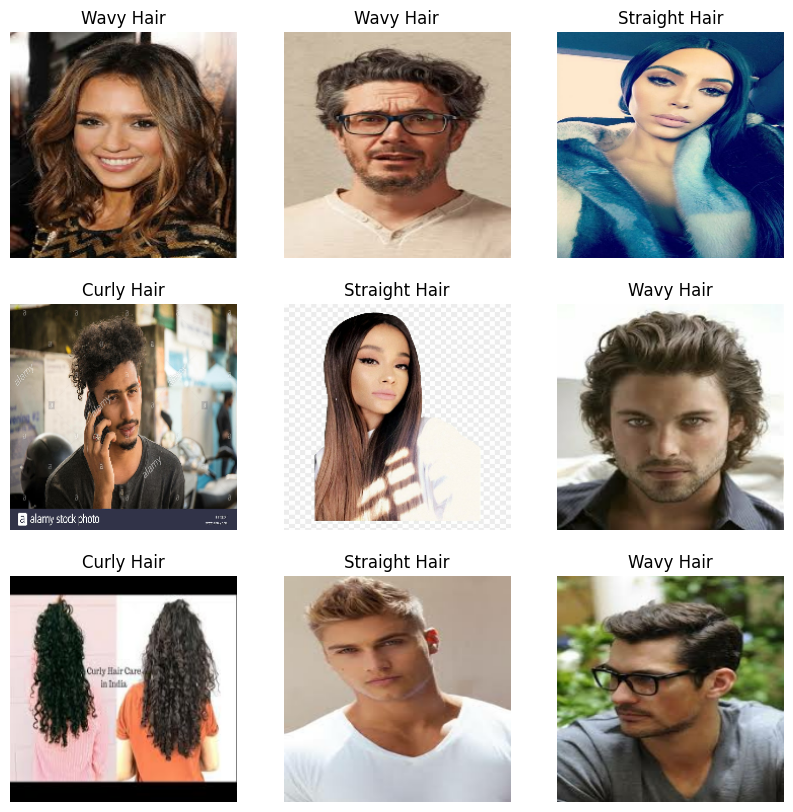

In [7]:
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(hair_types_labels[int(np.argmax(labels[i]))])
        plt.axis("off")
plt.show()

In [8]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(keras.Input(shape=image_size + (3,)))
model.add(layers.Rescaling(1.0 / 255))

model.add(layers.Conv2D(filters=16, kernel_size=3,
          strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(filters=32, kernel_size=3,
          strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=3,
          strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(filters=32, kernel_size=3,
          strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D())

# model.add(layers.Flatten()) # high results but it overfits

model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(64))
model.add(layers.Dropout(0.2))

model.add(layers.Activation("relu"))
model.add(layers.Dense(3))
model.add(layers.Dropout(0.2))

model.add(layers.Activation("softmax"))

# tf.keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True)

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 52, 52, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,659 (65.07 KB)

 Trainable params: 16,659 (65.07 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
epochs = 50
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
history

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.3131 - loss: 1.1014 - val_accuracy: 0.3350 - val_loss: 1.0986
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.3289 - loss: 1.1016 - val_accuracy: 0.4264 - val_loss: 1.0971
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.3678 - loss: 1.0973 - val_accuracy: 0.3401 - val_loss: 1.0906
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.3995 - loss: 1.0899 - val_accuracy: 0.4772 - val_loss: 1.0901
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.3650 - loss: 1.0940 - val_accuracy: 0.4061 - val_loss: 1.0718
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.3974 - loss: 1.0839 - val_accuracy: 0.3503 - val_loss: 1.0617
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.3635 - loss: 1.0893 - val_accuracy: 0.4721 - val_loss: 1.0731
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.4025 - loss: 1.0741 - val_accuracy: 0.

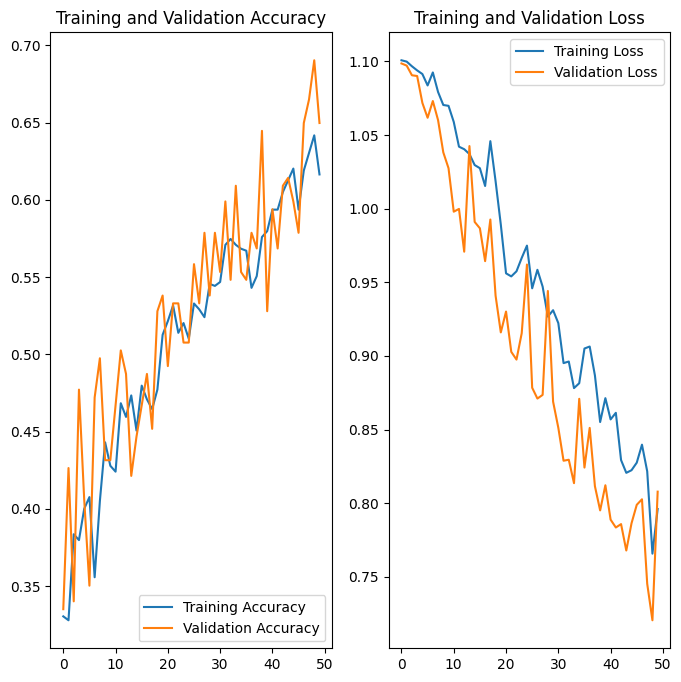

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
This image is 0.76 percent curly hair, 0.09 percent straight hair, and 0.16 percent wavy hair.


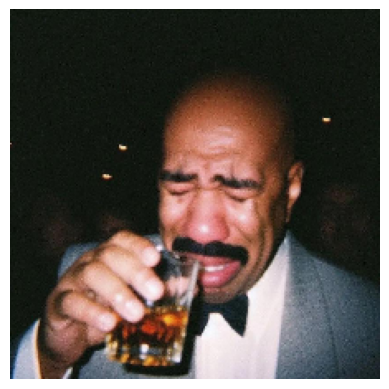

In [13]:
img = keras.preprocessing.image.load_img(
    "placeholder.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)

plt.axis("off")
plt.imshow(img)